In [4]:
import importlib
import numpy as np
import graph_analysis_functions as gaf
import pickle
importlib.reload(gaf)

<module 'graph_analysis_functions' from '/home/admin/Ana/MicroBrain/codes/Graph Analysis & by region/graph_analysis_functions.py'>

In [5]:
EDGE_NKIND_TO_LABEL = {
    2: "arteriole",
    3: "venule",
    4: "capillary"
}


[sync_vertex_attributes_safe] copied 2 attrs: ['coords_image_R', 'distance_to_surface_R']
The graph has 6 components. Keeping the largest one.

=== GIANT COMPONENT ===
Original: 814 V 931 E
Giant   : 792 V 912 E

=== Graph ===
IGRAPH U--- 792 912 -- 
+ attr: coords_image_R (v), distance_to_surface_R (v), id (v), diameter (e), geom_end (e), geom_start (e), length (e), length_R (e), length_tortuous (e), nkind (e), orig_eid (e), radius (e), tortuosity (e), tortuosity_R (e)
coords_attr: coords_image_R
box: {'xmin': 3212.5, 'xmax': 3612.5, 'ymin': 6625.0, 'ymax': 7025.0, 'zmin': 1675.0, 'zmax': 2075.0}

=== QC ===
Duplicates: {'n_pairs_duplicated': 8, 'n_extra_edges': 8, 'perc_extra_edges': 0.8771929824561403}
Loops: {'n_loops': 0, 'perc_loops': 0.0, 'loop_indices': []}

=== Edge type composition ===

Edge types:

 - arteriole (nkind=2): 72 edges (7.9%)
 - capillary (nkind=4): 840 edges (92.1%)

=== Mean length by nkind ===

Average length by nkind (space=um):

nkind = 2: average length (le

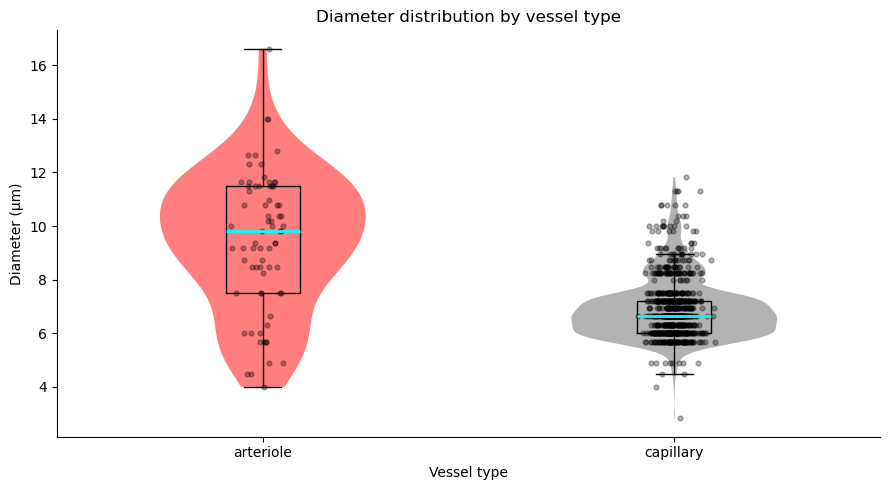


=== Degree / HDN ===
Unique degrees: [1 2 3 4 5 6]
HDN (>= 4): 37


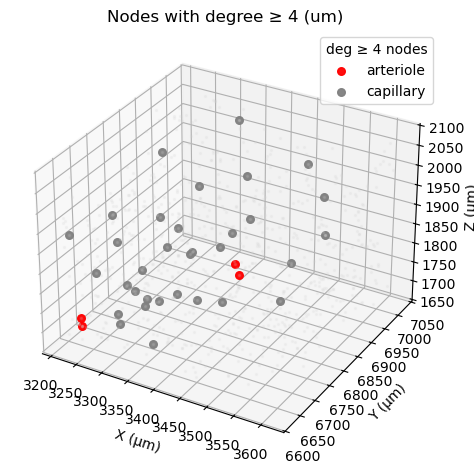

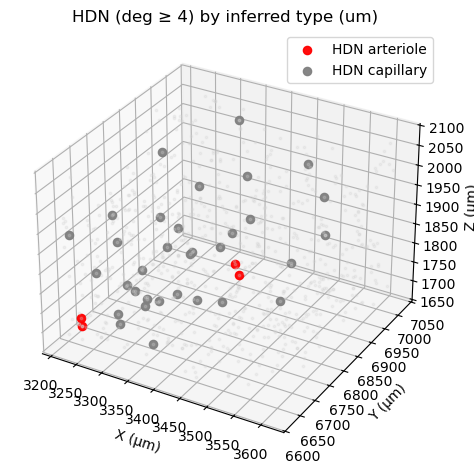


=== BC faces (faces-only) ===

BC table:
     Box   Face  BC nodes  % Arteriole  % Venule  % Capillary  % Unknown  \
0  Box0  x_min        44    11.363636       0.0    88.636364        0.0   
1  Box0  x_max        50     2.000000       0.0    98.000000        0.0   
2  Box0  y_min        69     5.797101       0.0    94.202899        0.0   
3  Box0  y_max        40     2.500000       0.0    97.500000        0.0   
4  Box0  z_min        73     2.739726       0.0    97.260274        0.0   
5  Box0  z_max        41     7.317073       0.0    92.682927        0.0   

   High degree %  
0       2.272727  
1       2.000000  
2       0.000000  
3       2.500000  
4       1.369863  
5       0.000000  


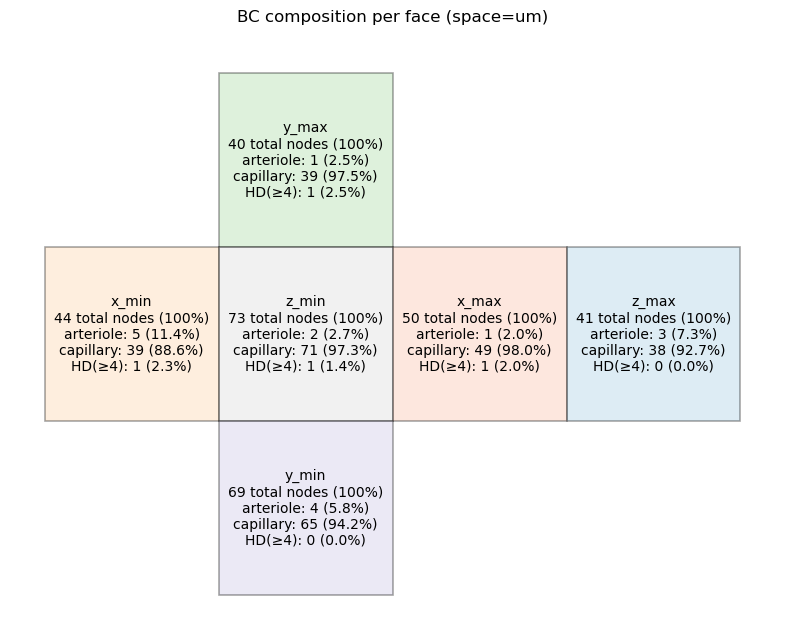

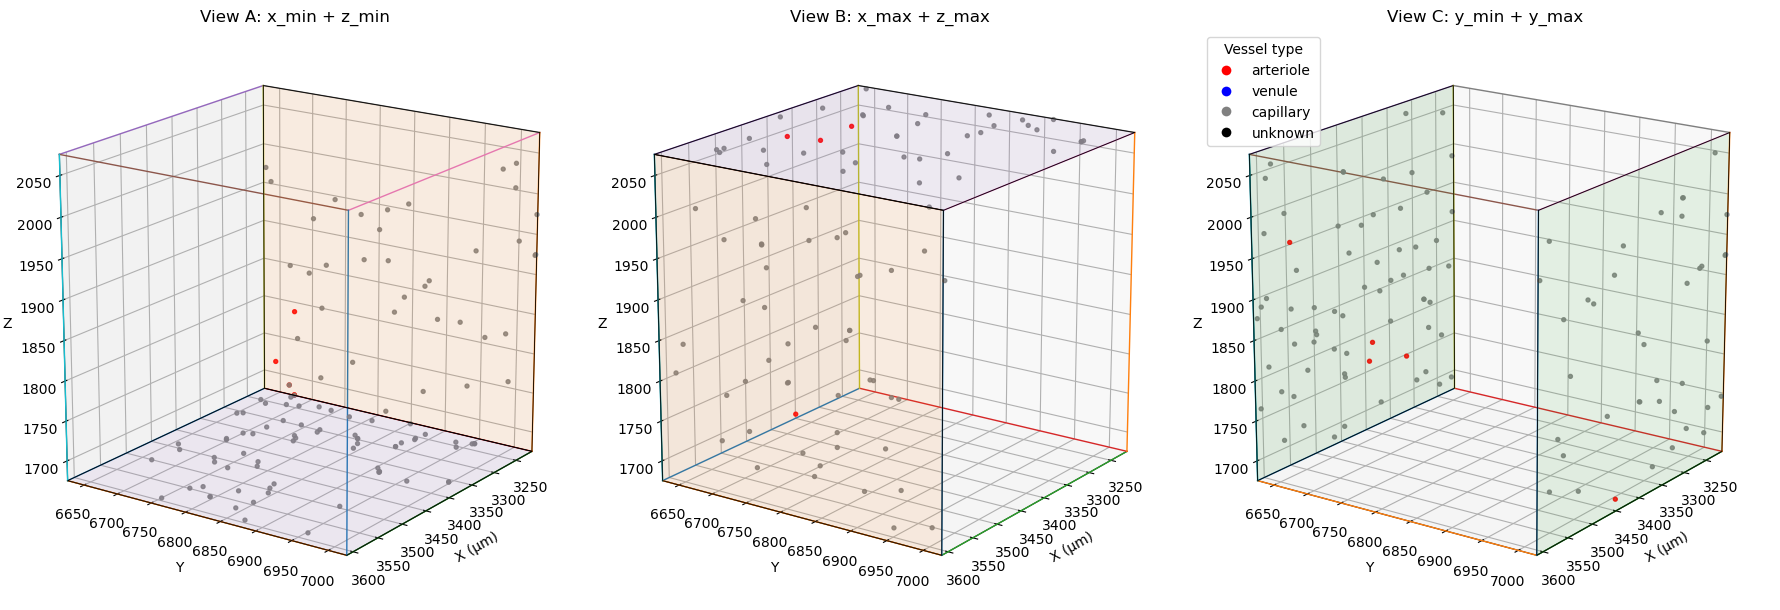


=== Gaia-style microsegments ===

=== Micro-segment counts (Gaia-style) ===
  nkind=2 (arteriole): 1326
  nkind=4 (capillary): 16047
  TOTAL micro-segments: 17373
Slab density skipped (likely missing atlas radii): microsegments radii contain NaN/inf. Build ms with atlas radii per point.

=== Simple A→V shortest paths (proxy) ===
Found 0 paths (requested 5).

Analysis finished.


In [ ]:
# --------------------------------------------------------------------------------------
# 1) IMPORT  MODULE 
# --------------------------------------------------------------------------------------
import graph_analysis_functions as gaf  


# --------------------------------------------------------------------------------------
# 2) USER INPUTS 
# --------------------------------------------------------------------------------------
DATA_PATH = "/home/admin/Ana/MicroBrain/output/graph_18_OutGeom_Hcut3_um.pkl"  
SPACE = "um"                        # "vox" or "um"
EPS_VOX = 2.0                        # ALWAYS in voxels (converted internally if SPACE="um")
DEGREE_THR = 4

# Box definition (center_vox from Paraview + size_um)
CENTER_VOX = [2100, 4200, 750]        # <-- from ParaView etc (in vox)
BOX_SIZE_UM = [400, 400, 400]        # <-- physical size

# Image resolution (for vox→µm conversions)
res_um_per_vox = np.array([1.625, 1.625, 2.5]) 

# Gaia density options
DO_GAIA = True
SLAB_UM = 50.0
SLAB_AXIS = "z"

# Redundancy (simple shortest paths)
DO_PATHS = True
K_PATHS = 5


# --------------------------------------------------------------------------------------
# 3) BUILD BOX CONSISTENT WITH SPACE
# --------------------------------------------------------------------------------------
if SPACE == "vox":
    box = gaf.make_box_in_vox(CENTER_VOX, BOX_SIZE_UM, res_um_per_vox=res_um_per_vox)
else:
    box = gaf.make_box_in_um(CENTER_VOX, BOX_SIZE_UM, res_um_per_vox=res_um_per_vox)

gaf.validate_box_faces(box)


# --------------------------------------------------------------------------------------
# 4) LOAD DATA + SYNC ATTRIBUTES
# --------------------------------------------------------------------------------------
data = gaf.load_data(DATA_PATH)            # dict with keys: graph, vertex, geom (+ _R optional)
data = gaf.sync_vertex_attributes_safe(data, space=SPACE)
G = data["graph"]

# keep only giant component
_, ncomp, data = gaf.single_connected_component(data)
G = data["graph"]

coords_attr = gaf.resolve_coords_attr(space=SPACE)
print("\n=== Graph ===")
print(G.summary())
print("coords_attr:", coords_attr)
print("box:", box)


# --------------------------------------------------------------------------------------
# 5) CLASSIC QC: DUPLICATES + LOOPS
# --------------------------------------------------------------------------------------
dup_stats = gaf.duplicated_edge_stats(G)
loop_stats = gaf.loop_edge_stats(G)
print("\n=== QC ===")
print("Duplicates:", dup_stats)
print("Loops:", loop_stats)


# --------------------------------------------------------------------------------------
# 6) EDGE TYPES + LENGTH + DIAMETER
# --------------------------------------------------------------------------------------
print("\n=== Edge type composition ===")
edge_types = gaf.get_edges_types(G, label_dict=gaf.EDGE_NKIND_TO_LABEL, return_dict=True)

print("\n=== Mean length by nkind ===")
try:
    gaf.get_avg_length_nkind(G, space=SPACE)
except Exception as e:
    print("Length-by-nkind skipped:", e)

print("\n=== Diameter stats by nkind (+ plot) ===")
try:
    diam_stats = gaf.diameter_stats_nkind(G, label_dict=EDGE_NKIND_TO_LABEL, ranges=None, plot=True)
except Exception as e:
    print("Diameter stats skipped:", e)


# --------------------------------------------------------------------------------------
# 7) DEGREE + HDN SPATIAL PLOTS
# --------------------------------------------------------------------------------------
print("\n=== Degree / HDN ===")
uniq_deg, hdn_idx = gaf.get_degrees(G, threshold=DEGREE_THR)

# Spatial plots 
gaf.plot_degree_nodes_spatial(
    G,
    space=SPACE,
    coords_attr=coords_attr,
    degree_min=DEGREE_THR,
    degree_max=None,
    by_type=True,
    title=f"Nodes with degree ≥ {DEGREE_THR} ({SPACE})"
)

# --------------------------------------------------------------------------------------
# 8) BC (FACES ONLY) + TABLE + PLOTS
# --------------------------------------------------------------------------------------
print("\n=== BC faces (faces-only) ===")
bc_res = gaf.analyze_bc_faces(
    G,
    box=box,
    space=SPACE,
    coords_attr=coords_attr,
    eps=EPS_VOX,              # ALWAYS in vox; internally converted if SPACE="um"
    degree_thr=DEGREE_THR,
    return_node_ids=False
)

bc_df = gaf.bc_faces_table(bc_res, box_name="Box0")
print("\nBC table:\n", bc_df)

gaf.plot_bc_cube_net(
    bc_res,
    title=f"BC composition per face (space={SPACE})",
    show_unknown=False,
    show_high_degree=True
)

gaf.plot_bc_3_cubes_tinted(
    G,
    box,
    space=SPACE,
    coords_attr=coords_attr,
    eps=EPS_VOX
)


# --------------------------------------------------------------------------------------
# 9) GAIA-STYLE MICROSEGMENTS (density / volume fraction slabs) [requires atlas radii]
# --------------------------------------------------------------------------------------
if DO_GAIA:
    print("\n=== Gaia-style microsegments ===")
    ms = gaf.microsegments(data, space="um")
    gaf.count_microsegments_by_nkind(ms)

    # box must be µm for slabs
    if SPACE == "um":
        box_um = box
    else:
        box_um = gaf.make_box_in_um(center_vox=CENTER_VOX,box_size_um=BOX_SIZE_UM, res_um_per_vox=res_um_per_vox)

    try:
        slabs_df = gaf.vessel_vol_frac_slabs_in_box(ms, box_um, slab=SLAB_UM, axis=SLAB_AXIS)
        print("\nSlabs volume fraction:\n", slabs_df)
    except Exception as e:
        print("Slab density skipped (likely missing atlas radii):", e)


# --------------------------------------------------------------------------------------
# 10) REDUNDANCY 
# --------------------------------------------------------------------------------------
if DO_PATHS:
    #first k A→V shortest paths
    print("\n=== Simple A→V shortest paths (proxy) ===")
    paths_orig = gaf.av_paths_in_box(
        G,
        box=box,
        k=K_PATHS,
        space=SPACE,
        coords_attr=coords_attr,
        node_eps=0.0
    )
    print(f"Found {len(paths_orig)} paths (requested {K_PATHS}).")
    # plot paths in box
    if len(paths_orig):
        gaf.plot_av_paths_in_box(
            G,
            box=box,
            paths_orig=paths_orig,
            space=SPACE,
            coords_attr=coords_attr,
            node_eps=0.0
        )

print("\nAnalysis finished.")


In [ ]:
path = "/home/admin/Ana/MicroBrain/output/graph_18_OutGeom_Hcut3_um.pkl"
res = np.array([1.625, 1.625, 2.5])
center = np.array([2100, 4200, 750])   # voxels
box_um = np.array([400, 400, 400])     # µm

box = gaf.make_box(center, box_um, res)

data = pickle.load(open(path, "rb"))
gaf.activate_space_inplace(data, space="um")

# Before any analysis, comply attributes:
gaf.sync_vertex_attributes(data)

G = data["graph"]

In [ ]:

# Checks if the graph is a single component. If not, saves the graph as the biggest connected component. 
_,_, G = gaf.single_connected_component(G)


# First, graph sanity check 
ed = gaf.duplicated_edge_stats(G)
loops = gaf.loop_edge_stats(G)
ed, loops

In [ ]:
# Nkinds 
unique, counts = gaf.get_edges_types(G)

unique, mean_diameter = gaf.get_avg_diameter_nkind(G)

stats = gaf.diameter_stats_nkind(G)

avg_length = gaf.get_avg_length_nkind(G)

unique_deg, hdn_idx = gaf.get_degrees(G, threshold=4)

gaf.analyze_hdn_pattern_in_box(G)

gaf.distance_to_surface_stats(G, hdn_idx)


gaf.analyze_hdn_pattern_in_box(
    G,
    degree_thr=4,
    box=box,  # si estás en ROI; si no, pon None
    coords_attr="coords_image",
    depth_attr="distance_to_surface",
)

In [ ]:
gr = G.es["diameter"]
n = G.es["nkind"]

gaf.plot_hist_by_category_general(gr, n, label_dict = EDGE_NKIND_TO_LABEL,
    variable_name="Diameter (µm)",
    main_title="Diameter distribution per vessel type")

BC ANALYSIS

In [ ]:
#Note: Faces are directly computed in the loop

bc_results = gaf.analyze_bc_faces(
    G,
    box=box,
    coords_attr="coords_image",
    eps=2.0,
    degree_thr=4,
    compute_types=True,
    compute_depth=True,
    return_node_ids=False,
    verbose=True
)


In [ ]:
gaf.plot_bc_3_cubes_tinted(G, box)

In [ ]:
gaf.plot_bc_cube_net(bc_results)

In [ ]:
gaf.plot_nkind_spatial_edges(G)

In [ ]:
gaf.plot_high_degree_nodes_by_type(G)


In [ ]:
gaf.bc_faces_table(bc_results)